In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SBSSBSBB'
m='PRCP'

In [2]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [3]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
# from pickle import load

# #read statistics
# filename=data_dir+'/STAT_%s.pickle'%file_index
# STAT,STAT_Descriptions = load(open(filename,'rb'))
# measurements=STAT.keys()
# print 'keys from STAT=',measurements

In [5]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1385.6| 41.2511|-111.9417|       PRCP|US1UTWB0017|    42|[00 7E 00 7E 00 7...|2011.0|SBSSBSBB|
|   1385.6| 41.2511|-111.9417|       PRCP|US1UTWB0017|    16|[00 00 00 00 00 0...|2012.0|SBSSBSBB|
|   1319.2| 41.7267|-112.1482|       PRCP|US1UTBE0008|     3|[00 00 00 00 00 0...|2011.0|SBSSBSBB|
|   1319.2| 41.7267|-112.1482|       PRCP|US1UTBE0008|     0|[00 00 00 00 00 0...|2012.0|SBSSBSBB|
|   1451.5| 42.0358|-111.9617|       PRCP|USC00109698|     0|[00 00 00 00 80 5...|1899.0|SBSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [6]:
sqlContext.registerDataFrameAsTable(df_in,'weather')
line='elevation'
Query="SELECT %s FROM weather\n\tGROUP BY %s ORDER BY %s LIMIT 1" %(line,line,line)
df_in1 = sqlContext.sql(Query)
print df_in1.count(),'rows'
df_in1.show(1)

1 rows
+---------+
|elevation|
+---------+
|   1289.3|
+---------+



In [7]:
sqlContext.registerDataFrameAsTable(df,'weather')
line='elevation'
Query="SELECT %s FROM weather\n\tGROUP BY %s ORDER BY %s DESC" %(line,line,line)
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show()

88 rows
+---------+
|elevation|
+---------+
|   2731.0|
|   2560.3|
|   2545.1|
|   2490.2|
|   2487.2|
|   2438.4|
|   2423.2|
|   2392.7|
|   2359.2|
|   2252.5|
|   2202.2|
|   2112.3|
|   2054.4|
|   1996.4|
|   1984.2|
|   1966.9|
|   1958.0|
|   1924.8|
|   1911.1|
|   1880.9|
+---------+
only showing top 20 rows



In [8]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT elevation, station, latitude, longitude FROM weather"
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(10)

2523 rows
+---------+-----------+--------+---------+
|elevation|    station|latitude|longitude|
+---------+-----------+--------+---------+
|   1385.6|US1UTWB0017| 41.2511|-111.9417|
|   1385.6|US1UTWB0017| 41.2511|-111.9417|
|   1319.2|US1UTBE0008| 41.7267|-112.1482|
|   1319.2|US1UTBE0008| 41.7267|-112.1482|
|   1451.5|USC00109698| 42.0358|-111.9617|
|   1451.5|USC00109698| 42.0358|-111.9617|
|   1451.5|USC00109698| 42.0358|-111.9617|
|   1451.5|USC00109698| 42.0358|-111.9617|
|   1451.5|USC00109698| 42.0358|-111.9617|
|   1451.5|USC00109698| 42.0358|-111.9617|
+---------+-----------+--------+---------+
only showing top 10 rows



In [9]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count"})
df2.show(10)

+-----------+--------+---------+---------+--------------+
|    station|latitude|longitude|elevation|count(station)|
+-----------+--------+---------+---------+--------------+
|USC00420487| 41.9583|-111.3922|   1806.9|            11|
|USS0011J68S| 40.9333|   -111.8|   2359.2|             2|
|USS0011G06S| 42.3667|-111.5667|   2252.5|            19|
|USW00024126| 41.1961|-112.0114|   1362.5|            18|
|USC00421450| 41.9167|  -112.05|   1533.1|            16|
|USC00427271| 41.9064|  -111.81|   1426.5|           100|
|USC00106785| 42.2333|   -111.4|   1818.4|            12|
|USS0011H57S| 41.4667|   -111.5|   2731.0|            21|
|USS0011G05S| 42.5667|   -111.3|   2202.2|            16|
|US1UTCH0004| 41.9221|-111.8193|   1394.8|             2|
+-----------+--------+---------+---------+--------------+
only showing top 10 rows



In [10]:

rows=df.rdd.map(lambda row:(row.elevation,row.year,unpackArray(row['vector'],np.float16))).collect()
temp=df.rdd.map(lambda row:(row.elevation,np.count_nonzero(~np.isnan(unpackArray(row['vector'],np.float16)))))
df2=sqlContext.createDataFrame(temp)
df2.show(2)
print type(df2)
pdf=df2.toPandas()
pdf.head(2)

+------+---+
|    _1| _2|
+------+---+
|1385.6|323|
|1385.6|349|
+------+---+
only showing top 2 rows

<class 'pyspark.sql.dataframe.DataFrame'>


_1   _2
0  1385.6  323
1  1385.6  349

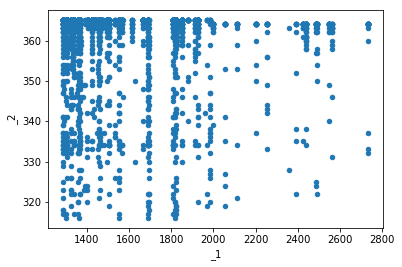

In [11]:
%matplotlib inline
pdf.plot.scatter(x='_1',y='_2')

In [14]:


## combine the measurements for each station into a single long array with an entry for each day of each day
All_count={}  # a dictionary with a numpy array for each day of each day
i=0
for elevation,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not elevation in All_count:
        All_count[elevation]=[np.count_nonzero(vector[~np.isnan(vector)]),1]
    All_count[elevation][0]+=np.count_nonzero(vector[~np.isnan(vector)])
    All_count[elevation][1]+=1
for elevation in All_count:
    All_count[elevation]=All_count[elevation][0]/All_count[elevation][1]
print All_count

{1451.5: 76, 1362.5: 84, 1393.5: 100, 1358.5: 74, 1552.0: 111, 1371.6: 96, 1806.2: 86, 1694.7: 66, 1533.1: 54, 2490.2: 139, 1373.1: 61, 1324.1: 74, 1367.9: 91, 1357.6: 97, 1551.4: 87, 1439.9: 95, 1822.7: 69, 1984.2: 81, 1307.6: 91, 1479.5: 32, 1505.7: 96, 1304.5: 69, 1402.1: 76, 2252.5: 131, 1626.7: 71, 1368.9: 89, 2731.0: 129, 2359.2: 99, 2487.2: 114, 2054.4: 106, 1924.8: 69, 1473.1: 91, 1289.3: 65, 1357.9: 97, 1849.8: 67, 1566.7: 93, 1880.9: 76, 2545.1: 107, 1996.4: 105, 2112.3: 103, 1330.1: 105, 2202.2: 121, 1817.8: 114, 1966.9: 62, 2560.3: 119, 1435.9: 94, 1292.0: 91, 1325.9: 82, 1665.7: 91, 1911.1: 84, 2423.2: 111, 1338.7: 86, 1366.1: 83, 1806.9: 85, 1554.5: 63, 1359.4: 84, 1319.2: 88, 1335.0: 82, 1360.0: 72, 1390.5: 81, 1302.1: 75, 2438.4: 120, 1365.8: 95, 1383.2: 62, 1294.8: 89, 1341.1: 77, 1406.0: 86, 1493.5: 93, 1828.8: 116, 1569.4: 95, 1459.1: 83, 1816.6: 97, 1958.0: 134, 1352.1: 121, 1460.0: 89, 1463.0: 89, 1464.6: 104, 1447.8: 95, 1818.4: 72, 2392.7: 124, 1426.5: 98, 1385.6

In [15]:
# All_count={};
# for elevation in All:
#     All_count[elevation]=np.count_nonzero(~np.isnan(All[elevation]))
# print All_count

+---------+----------+
|elevation|rainy_days|
+---------+----------+
|   1451.5|        76|
|   1362.5|        84|
+---------+----------+
only showing top 2 rows

+---------+----------+
|elevation|rainy_days|
+---------+----------+
|   2731.0|       129|
|   2560.3|       119|
|   2545.1|       107|
|   2490.2|       139|
|   2487.2|       114|
|   2438.4|       120|
|   2423.2|       111|
|   2392.7|       124|
|   2359.2|        99|
|   2252.5|       131|
|   2202.2|       121|
|   2112.3|       103|
|   2054.4|       106|
|   1996.4|       105|
|   1984.2|        81|
|   1966.9|        62|
|   1958.0|       134|
|   1924.8|        69|
|   1911.1|        84|
|   1880.9|        76|
+---------+----------+
only showing top 20 rows



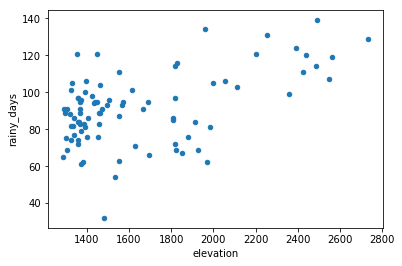

In [16]:
##plot
sort_ele=[]
for eleva in All_count:
    sort_ele.append(Row(elevation=eleva,rainy_days=All_count[eleva]))
some_rdd = sc.parallelize(sort_ele)
some_df = sqlContext.createDataFrame(some_rdd)
some_df.show(2)
sqlContext.registerDataFrameAsTable(some_df,'ele_snow')
Query="SELECT * FROM ele_snow ORDER BY elevation DESC"
some_df = sqlContext.sql(Query)
some_df.show()
pdf2=some_df.toPandas()
pdf2.sort_values(by=['elevation'],inplace=True)
pdf2.head(2)
%matplotlib inline
pdf2.plot.scatter(x='elevation',y='rainy_days')

In [14]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
m='TOBS'
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2257.3| 41.7833|-111.5333|       TOBS|USS0011H58S|    32|[00 7E 00 7E 00 7...|2003.0|SBSSBSBB|
|   2257.3| 41.7833|-111.5333|       TOBS|USS0011H58S|    19|[40 D2 A0 D7 A0 D...|2004.0|SBSSBSBB|
|   2257.3| 41.7833|-111.5333|       TOBS|USS0011H58S|     5|[00 D3 80 D1 20 D...|2005.0|SBSSBSBB|
|   2257.3| 41.7833|-111.5333|       TOBS|USS0011H58S|    20|[80 D1 00 00 80 C...|2006.0|SBSSBSBB|
|   2257.3| 41.7833|-111.5333|       TOBS|USS0011H58S|     4|[30 D4 00 CF 80 4...|2007.0|SBSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [24]:
another_rows=df.rdd.map(lambda row:(row.year,np.nanmean(unpackArray(row['vector'],np.float16)))).collect()

All_tem={}  # a dictionary with a numpy array for each day of each day
i=0
for year,sca in another_rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not year in All_tem:
        All_tem[year]=int(sca)/10
    All_tem[year]=max(All_tem[year],int(sca)/10)

+----------+------+
|centigrade| years|
+----------+------+
|        10|1901.0|
|        11|1902.0|
+----------+------+
only showing top 2 rows

+----------+------+
|centigrade| years|
+----------+------+
|        10|1901.0|
|        11|1902.0|
|        12|1903.0|
|         9|1904.0|
|         7|1905.0|
|         6|1906.0|
|         8|1907.0|
|         8|1908.0|
|         9|1909.0|
|        11|1910.0|
|         9|1911.0|
|        11|1912.0|
|        11|1913.0|
|        12|1914.0|
|        13|1915.0|
|        12|1916.0|
|        12|1917.0|
|        13|1918.0|
|        13|1919.0|
|        11|1920.0|
+----------+------+
only showing top 20 rows



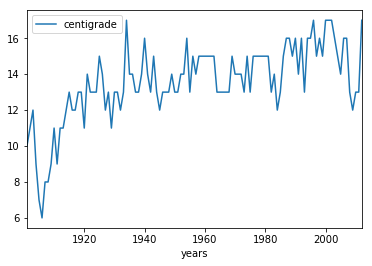

In [25]:
##plot
sort_ele=[]
for year in All_tem:
    sort_ele.append(Row(years=year,centigrade=All_tem[year]))
some_rdd = sc.parallelize(sort_ele)
some_df = sqlContext.createDataFrame(some_rdd)
some_df.show(2)
sqlContext.registerDataFrameAsTable(some_df,'ele')
Query="SELECT * FROM ele ORDER BY years"
some_df = sqlContext.sql(Query)
some_df.show()
pdf2=some_df.toPandas()
pdf2.head(2)
%matplotlib inline
pdf2.plot(x='years',y='centigrade')

In [17]:
sc.stop()